## Table Of Contents: <a class="anchor" id="TableOfContents"></a>
* [Imports And Settings](#Imports)
* [Meta Functions](#Functions)
* [Spreadsheets](#Spreadsheets)
* [Main DataFrame](#MainDataFrame) 
  * [Corrections](#Corrections) 
  * [Groups](#Groups) 
  * [Confirm DataFrame](#ConfirmPrimary)
  * [Age Column](#Age)
  * [Breakdown](#Breakdown)
* [Citations](#Citations) 
* [Combined Effects](#CombinedEffects) 
* [All Groups](#AllGroups) 
* [Stats_DataFrame](#StatsDataFrame) 
* [Analysis](#Analysis)

## Imports and Settings <a class="anchor" id="Imports"></a>

In [1]:

from scipy.stats import norm, ttest_ind, shapiro, normaltest, anderson, chisquare
from pandas.core.common import SettingWithCopyWarning
from IPython.display import display, Math, Latex
from scipy.optimize import minimize, curve_fit
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches                                                       # Figure Legends
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import numpy as np
import time as t0
import subprocess
import warnings
import copy

## Numpy Settings
np.set_printoptions(threshold=np.inf, precision=3, linewidth=300, suppress=True)
np.seterr(divide='ignore', invalid='ignore')

## Pandas Settings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.width'      , 1000, 
              'expand_frame_repr'  , False,
              'display.max_rows'   , 999,
              'display.max_columns', 999)


## Figure Parameters
plt.rcParams["font.family" ] = 'Myriad Pro'
plt.rcParams["pdf.fonttype"] = 42


## Meta Functions and Ratio Approximations <a class="anchor" id="Functions"></a>
 - [Return to Table of Contents](#TableOfContents)

In [2]:
from supp_functions import *

## Spreadsheets <a class="anchor" id="Spreadsheets"></a>

In [3]:
refname  = 'References_Concentrations.csv'
valname  = 'Values_Concentrations.csv'

dfR              = pd.read_csv('References_Concentrations.csv', encoding='latin')
dfR.Complete     = dfR.Complete.fillna('0')
dfR.Complete     = dfR.Complete.replace('X', '1')
dfR.Complete     = dfR.Complete.astype(int)

dfC              = pd.read_csv('Values_Concentrations.csv', encoding='latin')
dfC.ID           = dfC.ID.astype(int)
dfC              = dfC.fillna(0)
dfR.Control_ID   = dfR.Control_ID.astype(str)
dfR.Treatment    = dfR.Treatment.astype(str)

dfR              = dfR.fillna(0)
dfR['Year']      = dfR['Reference'].astype(str).str[:4]

dfR_             = dfR[dfR.Complete == 1].reset_index(drop=True)

dfR              = copy.deepcopy(dfR_)

ignore           = [] # '2019_meyer_10', '2018_sheth_276', '2018_sivaraman_281', '2019_girgis_275','2020_sheth_123'] 
screen           = [] # '2018_galinska-skok_2018', '2018_karczewska-kupczewska_103', '2018_atagun_235','2018_veeramuthu_25']

article_cntrl  = list(sorted(set(dfR.Reference)))
article_cntrl.remove('2021_coughlin_26')                                            # Duplicate of 2020 Coughlin
print('Creating Primary DataFrame')
print('    Unique Articles: {:3d}'.format(len(article_cntrl)))
print('    Total Groups   : {:3d}'.format(dfR.shape[0]))


Creating Primary DataFrame
    Unique Articles: 350
    Total Groups   : 2553


## Create Main DataFrame <a class="anchor" id="MainDataFrame"></a>
 - [Return to Table of Contents](#TableOfContents)

In [4]:

df_main             = pd.DataFrame()
for ii in range(len(article_cntrl)):

    print('{:3d} {}'.format(ii, article_cntrl[ii]))
    dfC_current     = dfC[dfC.Reference.str.contains(article_cntrl[ii])].reset_index(drop=True)

    dfR_current     = dfR[dfR.Reference.str.contains(article_cntrl[ii])].reset_index(drop=True)
    dfR_current_    = dfR_current[~dfR_current.Control_ID.str.contains('No Control')].reset_index(drop=True)
    dfR_current_.ID = dfR_current_.ID.astype(int)   
    
    idxs            = []
    idxs_           = list(dfR_current_.ID)
    cidxs           = []
    cidxs_          = list(dfR_current_.Control_ID)
        
    for jj in range(len(cidxs_)):
        cidxs_[jj] = cidxs_[jj].replace(' ', '').split(',')        
        for kk in range(len(cidxs_[jj])):
            idxs.append(idxs_[jj])
            cidxs.append(int(cidxs_[jj][kk]))
                
    for jj in range(len(idxs)):
        dfR_current_jj      = dfR_current_[dfR_current_.ID ==  idxs[jj]].reset_index(drop=True)
        dfR_current_control = dfR_current[ dfR_current.ID  == cidxs[jj]].reset_index(drop=True)

        dfC_current_exper   = dfC_current[ dfC_current.ID  ==  idxs[jj]].reset_index(drop=True)
        dfC_current_control = dfC_current[ dfC_current.ID  == cidxs[jj]].reset_index(drop=True)

        metabs_exper        = list(set(dfC_current_exper.Name))
        metabs_control      = list(set(dfC_current_control.Name))
        metabs_             = []
        for kk in list(set([*metabs_exper, *metabs_control])):
            if kk in metabs_exper and kk in metabs_control:
                metabs_.append(kk)
        
        for kk in range(len(metabs_)):
            try:
                dfC_current_exper_   = dfC_current_exper[dfC_current_exper.Name == metabs_[kk]].reset_index(drop=True)
                dfC_current_control_ = dfC_current_control[dfC_current_control.Name == metabs_[kk]].reset_index(drop=True)
                
                dfR_current_kk  = copy.deepcopy(dfR_current_jj)
                dfR_current_kk['Metabolite'] = metabs_[kk]
                
                if int(dfR_current_jj['N_Exclusions'][0]) == 0:
                    dfR_current_kk['Clinical_N' ] = int(dfR_current_jj[     'N_Total'     ][0])
                else:   
                    dfR_current_kk['Clinical_N' ] = int(dfR_current_jj[     'N_Exclusions'][0])
                
                if int(dfR_current_control['N_Exclusions' ][0]) == 0:
                    dfR_current_kk['Control_N'  ] = int(dfR_current_control['N_Total'     ][0])
                else:
                    dfR_current_kk['Control_N'  ] = int(dfR_current_control['N_Exclusions'][0])

                dfR_current_kk['Clinical_Cr_u'  ] = float(dfC_current_exper_['tCr_u' ][0])
                dfR_current_kk['Clinical_Cr_std'] = float(dfC_current_exper_['tCr_std'][0])
                dfR_current_kk['Control_Cr_u'   ] = float(dfC_current_control_['tCr_u' ][0])
                dfR_current_kk['Control_Cr_std' ] = float(dfC_current_control_['tCr_std'][0])
                
                dfR_current_kk['Clinical_IU_u'  ] = float(dfC_current_exper_['IU_u'][0])
                dfR_current_kk['Clinical_IU_std'] = float(dfC_current_exper_['IU_std'][0])
                dfR_current_kk['Control_IU_u'   ] = float(dfC_current_control_['IU_u'][0])
                dfR_current_kk['Control_IU_std' ] = float(dfC_current_control_['IU_std'][0])
                
                dfR_current_kk['Clinical_mM_u'  ] = float(dfC_current_exper_['mM_u'][0])
                dfR_current_kk['Clinical_mM_std'] = float(dfC_current_exper_['mM_std'][0])
                dfR_current_kk['Control_mM_u'   ] = float(dfC_current_control_['mM_u'][0])
                dfR_current_kk['Control_mM_std' ] = float(dfC_current_control_['mM_std'][0])
                                
                Friedrich_Cr = ratio_Friedrich(dfR_current_kk.Clinical_N[0],
                                               dfR_current_kk.Control_N[0], 
                                               dfR_current_kk.Clinical_Cr_u[0],
                                               dfR_current_kk.Control_Cr_u[0], 
                                               dfR_current_kk.Clinical_Cr_std[0],
                                               dfR_current_kk.Control_Cr_std[0]) 
                
                Friedrich_IU = ratio_Friedrich(dfR_current_kk.Clinical_N[0],
                                               dfR_current_kk.Control_N[0], 
                                               dfR_current_kk.Clinical_IU_u[0],
                                               dfR_current_kk.Control_IU_u[0], 
                                               dfR_current_kk.Clinical_IU_std[0],
                                               dfR_current_kk.Control_IU_std[0]) 

                Friedrich_mM = ratio_Friedrich(dfR_current_kk.Clinical_N[0],
                                               dfR_current_kk.Control_N[0], 
                                               dfR_current_kk.Clinical_mM_u[0],
                                               dfR_current_kk.Control_mM_u[0], 
                                               dfR_current_kk.Clinical_mM_std[0],
                                               dfR_current_kk.Control_mM_std[0])  
                
                dfR_current_Cr = copy.deepcopy(dfR_current_kk)
                dfR_current_IU = copy.deepcopy(dfR_current_kk)
                dfR_current_mM = copy.deepcopy(dfR_current_kk)

                dfR_current_Cr['Units'           ] = 'Cr'           
                dfR_current_Cr['Friedrich_u'     ] =   Friedrich_Cr['Ratio']
                dfR_current_Cr['Friedrich_Var'   ] =   Friedrich_Cr['Var'  ]
                dfR_current_Cr['Friedrich_Weight'] = 1/Friedrich_Cr['Var'  ]
                dfR_current_Cr['Friedrich_SE'    ] =   Friedrich_Cr['SE'   ]
                dfR_current_Cr['Friedrich_Low'   ] =   Friedrich_Cr['Low'  ]
                dfR_current_Cr['Friedrich_Hgh'   ] =   Friedrich_Cr['Hgh'  ]                
                
                if Friedrich_Cr['Ratio'] > .001:
                    if dfR_current_Cr.Reference[0] not in ignore:                           # Skip - See Reference Notes
                        df_main = pd.concat([df_main, dfR_current_Cr])
                            
                dfR_current_IU['Units'           ] = 'IU'           
                dfR_current_IU['Friedrich_u'     ] =   Friedrich_IU['Ratio']
                dfR_current_IU['Friedrich_Var'   ] =   Friedrich_IU['Var'  ]
                dfR_current_IU['Friedrich_Weight'] = 1/Friedrich_IU['Var'  ]
                dfR_current_IU['Friedrich_SE'    ] =   Friedrich_IU['SE'   ]
                dfR_current_IU['Friedrich_Low'   ] =   Friedrich_IU['Low'  ]
                dfR_current_IU['Friedrich_Hgh'   ] =   Friedrich_IU['Hgh'  ]                    

                if Friedrich_IU['Ratio'] > .001:
                    if dfR_current_Cr.Reference[0] not in ignore and dfR_current_Cr.Reference[0] not in screen: # Skip - See Reference Notes
                        df_main = pd.concat([df_main, dfR_current_IU])

                dfR_current_mM['Units'           ] = 'mM'           
                dfR_current_mM['Friedrich_u'     ] =   Friedrich_mM['Ratio']
                dfR_current_mM['Friedrich_Var'   ] =   Friedrich_mM['Var'  ]
                dfR_current_mM['Friedrich_Weight'] = 1/Friedrich_mM['Var'  ]
                dfR_current_mM['Friedrich_SE'    ] =   Friedrich_mM['SE'   ]
                dfR_current_mM['Friedrich_Low'   ] =   Friedrich_mM['Low'  ]
                dfR_current_mM['Friedrich_Hgh'   ] =   Friedrich_mM['Hgh'  ]             
                
                if Friedrich_mM['Ratio'] > .001:
                    if dfR_current_Cr.Reference[0] not in ignore:                           # Skip - See Reference Notes
                        df_main = pd.concat([df_main, dfR_current_mM])
                                      
            except Exception as e:
                print(e)
                display(dfR_current_kk)
                

  0 2008_shih_28
  1 2010_terpstra_24
  2 2014_gomar_75
  3 2015_calderon-garciduenas_48
  4 2015_glodzik_43
  5 2015_guo_15
  6 2015_seraji-bozorgzad_30
  7 2015_simoes_213
  8 2015_snoussi_74
  9 2016_deelchand_29
 10 2016_guo_69
 11 2016_howells_31
 12 2016_koob_11
 13 2016_mazuel_278
 14 2016_wu_206
 15 2017_atagun_637
 16 2017_barbagallo_43
 17 2017_brennan_269
 18 2017_cao_42
 19 2017_carlson_38
 20 2017_cheong_42
 21 2017_craciunas_26
 22 2017_holmes_12
 23 2017_li_42
 24 2017_marjanska_354
 25 2017_shimizu_82
 26 2017_sijens_42
 27 2017_simoes_216
 28 2017_suri_152
 29 2017_zeydan_27
 30 2018_adanyeguh_31
 31 2018_al-iedani_108
 32 2018_an_79
 33 2018_an_80
 34 2018_atagun_235
 35 2018_barbagallo_47
 36 2018_barta_18
 37 2018_bauer_19
 38 2018_bednarik_38
 39 2018_berrington_31
 40 2018_bossong_21
 41 2018_bradley_86
 42 2018_burger_185
 43 2018_cadena_9
 44 2018_cao_28
 45 2018_caravaggio_28
 46 2018_chiu_193
 47 2018_cichocka_83
 48 2018_cirstea_97
 49 2018_deelchand_79
 50 2

## Correct Parkinson's String Error <a class="anchor" id="Corrections"></a>
Not sure what the deal is here.. The string reads correctly on the CSV, yet seems to have issues when reading in from PANDAS. 

In [5]:

print('df_main {:<10} {}'.format('Original:', df_main.shape[0]))

## Copy and Correct Rows with String Error
df_ignore = df_main[df_main.Group.str.contains('Parkinsonâ\x80\x99s')].reset_index(drop=True)
df_ignore.Group = 'Parkinson\'s'

## Remove from df_main
df_main = df_main[~df_main.Group.str.contains('Parkinsonâ\x80\x99s')].reset_index(drop=True)
print('df_main {:<10} {}'.format('Updated:', df_main.shape[0]))

df_main = pd.concat([df_main, df_ignore])
df_main = df_main.reset_index(drop=True)
print('df_main {:<10} {}'.format('Final:', df_main.shape[0]))



df_main Original:  5196
df_main Updated:   5190
df_main Final:     5196


## Groups Included: <a class="anchor" id="Groups"></a>

In [6]:
all_groups = list(sorted(set(df_main.Group)))

print('{} Groups within df_main:'.format(len(all_groups)))
for ii in range(len(all_groups)):
    print('{:2d} {}'.format(ii, all_groups[ii]))

53 Groups within df_main:
 0 ADHD
 1 ALS
 2 APOE4
 3 Addiction
 4 Aged
 5 Autism
 6 Bipolar
 7 Cancer
 8 Child
 9 Control
10 Dementia
11 Depression
12 DiGeorge Syndrome
13 Diabetes
14 Diabetes1
15 Diabetes2
16 Dyslexia
17 Essential Tremor
18 Fibromyalgia
19 Glaucoma
20 HIV
21 Healthy
22 Huntington's
23 Infection
24 Insomnia
25 Lifestyle
26 MCI
27 MELAS
28 Metabolic Disorder
29 Migraine
30 Multiple Sclerosis
31 NAFLD
32 Neurodegeneration
33 OCD
34 Orthostatic Intolerance
35 PTSD
36 Pain
37 Parkinson's
38 Perinatal_Complications
39 Periphery
40 Personality Disorder
41 Preterm
42 Psychosis
43 SCI
44 Schizophrenia
45 Seizure
46 Stress
47 Stroke
48 TBI
49 Task
50 Tension-Type Headache
51 Tourrettes
52 Trauma


## Confirm Primary DataFrame <a class="anchor" id="ConfirmPrimary"></a>

In [7]:

def confirm_dataframe(df, reference):
    display(df[df.Reference.str.contains(reference)].reset_index(drop=True)[['Reference', 'Group', 'ID', 'Metabolite', 'Voxel_Region', 'Left/Right/Both', 'Friedrich_u']])

confirm_dataframe(df_main, '2017_barbagallo_43')

,Reference,Group,ID,Metabolite,Voxel_Region,Left/Right/Both,Friedrich_u
0,2017_barbagallo_43,Parkinson's,4,GPC,Thalamus,Contralateral,0.818182
1,2017_barbagallo_43,Parkinson's,4,Glu,Thalamus,Contralateral,0.938017
2,2017_barbagallo_43,Parkinson's,4,NAA,Thalamus,Contralateral,0.774194
3,2017_barbagallo_43,Parkinson's,4,GPC,Thalamus,Contralateral,0.729730
4,2017_barbagallo_43,Parkinson's,4,Glu,Thalamus,Contralateral,1.170103
5,2017_barbagallo_43,Parkinson's,4,NAA,Thalamus,Contralateral,0.862275
6,2017_barbagallo_43,Parkinson's,5,GPC,Thalamus,Ipsilateral,0.818182
7,2017_barbagallo_43,Parkinson's,5,Glu,Thalamus,Ipsilateral,0.938017
8,2017_barbagallo_43,Parkinson's,5,NAA,Thalamus,Ipsilateral,0.768817
9,2017_barbagallo_43,Parkinson's,5,GPC,Thalamus,Ipsilateral,0.729730


#### Add in the Age Column  <a class="anchor" id="Age"></a>

In [8]:

def make_age_column(df,):
    
    age_ranges    = np.arange(0, 100)
    age_ranges[0] = 0.001
    ages          = []

    print('DataFrame Initial Shape: ', df.shape)

    for ii in range(df.shape[0]):
        app     = 0

        try:    
            age = float(df.Age[ii])
            for jj in range(1, age_ranges.shape[0]):
                if app == 0:
                    if age == 0:
                        print('No Age Given: ', df.Reference[ii], df_main.Age[ii])
                        ages.append('NA')
                        app = 1

                    elif age >= age_ranges[jj-1] and age < age_ranges[jj]:
                        ages.append(age_ranges[jj-1])
                        app = 1

            if app == 0:
                print(df.Reference[ii], df_main.Age[ii])
        except:
            ages.append(30)
            print(df.Reference[ii], df_main.Age[ii])
    
    df['Age_Order'] = ages
    print('DataFrame Final Shape  : ', df.shape)

    return df

df_main  = make_age_column(df_main)

DataFrame Initial Shape:  (5196, 81)
DataFrame Final Shape  :  (5196, 82)


#### Breakdown Clinical Populations  <a class="anchor" id="Breakdown"></a>

In [9]:
df_main.Treatment = df_main.Treatment.astype(int)

clin_class    = {
    'Development'      : [['Perinatal_Complications', 'Autism', 'ADHD'                           ],0,[]],
    'Neurodegenerative': [['MCI', 'APOE4', 'Dementia', 'Essential Tremor', 'Parkinson\'s', 
                           'Multiple Sclerosis',                                                 ],0,[]],
    'Psychiatric1'     : [['Bipolar', 'Personality Disorder', 'Psychosis', 'Schizophrenia',      ],0,[]],
    'Psychiatric2'     : [['Addiction', 'Depression', 'OCD', 'PTSD',                             ],0,[]],
    
    'Pain'             : [['Fibromyalgia', 'Migraine', 'Pain'                                    ],0,[]],
    'Metabolic'        : [['Cancer', 'Diabetes1',                                                ],0,[]],
    'Trauma'           : [['TBI', 'Stroke', 'Seizure',                                           ],0,[]],
                }

short_names = {}
short_names['Perinatal_Complications'] = 'PC'
short_names['Autism'                 ] = 'Aut'
short_names['ADHD'                   ] = 'ADHD'
short_names['MCI'                    ] = 'MCI'
short_names['APOE4'                  ] = 'E4'
short_names['Dementia'               ] = 'Dem'
short_names['Essential Tremor'       ] = 'ETrm'
short_names['Parkinson\'s'           ] = 'PD'
short_names['Multiple Sclerosis'     ] = 'MS'
short_names['Seizure'                ] = 'Seiz'
short_names['Addiction'              ] = 'Adc'
short_names['Personality Disorder'   ] = 'Pers'
short_names['Depression'             ] = 'Depr'
short_names['OCD'                    ] = 'OCD'
short_names['Bipolar'                ] = 'Bip'
short_names['Schizophrenia'          ] = 'Schz'
short_names['Psychosis'              ] = 'Psy'
short_names['PTSD'                   ] = 'PTSD'
short_names['Fibromyalgia'           ] = 'Fib'
short_names['Migraine'               ] = 'Mgrn'
short_names['Pain'                   ] = 'Pain'
short_names['Cancer'                 ] = 'Canc'
short_names['Diabetes1'              ] = 'D1'
short_names['TBI'                    ] = 'TBI'
short_names['Stroke'                 ] = 'Str'

clin_healthy  = ['Control', 'Healthy', 'Task']
clin_class_   = list(clin_class.keys())

all_groups    = []
all_groups.extend(clin_class['Development'      ][0])
all_groups.extend(clin_class['Neurodegenerative'][0])
all_groups.extend(clin_class['Psychiatric1'     ][0])
all_groups.extend(clin_class['Psychiatric2'     ][0])
all_groups.extend(clin_class['Pain'             ][0])
all_groups.extend(clin_class['Metabolic'        ][0])
all_groups.extend(clin_class['Trauma'           ][0])

grpsum        = 0
papsum        = 0

df_clin_cite  = pd.DataFrame({})

print('Papers with Control Group')
print('  ii  jj       Class            Group            NGroups  NPapers')
for ii in range(len(clin_class_)):
    clin_class[clin_class_[ii]][1] = np.zeros([len(clin_class[clin_class_[ii]][0]),2])
        
    cls_grpsum = 0
    cls_papsum = 0

    for jj in range(len(clin_class[clin_class_[ii]][0])):
        
        current      = clin_class[clin_class_[ii]][0][jj]
        df_main_     = df_main[ df_main.Group.str.contains(current)].reset_index(drop=True)
        df_main_     = df_main_[df_main_.Treatment == 0].reset_index(drop=True)
        df_main_paps = list(sorted(set(df_main_.Reference)))
        
        # print(' ')
        for kk in range(len(df_main_paps)):
            df_main_paps_ = df_main_[df_main_.Reference == df_main_paps[kk]].reset_index(drop=True)
            df_main_paps_['Class'] = clin_class_[ii]
            df_main_paps_['Group'] = current
            
            if '2021_coughlin' not in df_main_paps[kk]:
                # display(df_main_paps_)
            
                df_clin_cite = pd.concat([df_clin_cite, df_main_paps_[['DOI', 'Reference', 'Title', 'Class', 'Group']].head(1)])
                # print('{:3d} {:<20} {:<40}  {:<20}  {:<20} {}'.format(ii, df_main_paps_.Reference[0][:20], df_main_paps_.Title[0][:40], df_main_paps_.Class[0][:20], df_main_paps_.Group[0][:20], df_main_paps_.DOI[0]))
        
        clin_class[clin_class_[ii]][1][jj,0] += df_main_.shape[0]
        clin_class[clin_class_[ii]][1][jj,1] += len(df_main_paps)

        grpsum      += df_main_.shape[0]
        papsum      += len(df_main_paps)

        cls_grpsum  += df_main_.shape[0]
        cls_papsum  += len(df_main_paps)
        
        clin_class[clin_class_[ii]][2].append(copy.deepcopy(df_main_))

        if jj < len(clin_class[clin_class_[ii]][0])-1:
            print('{:3d}:{:3d}  |  {:<15}  |  {:<15}  |  {:4.0f} {:5.0f}  |'.format(ii, jj, clin_class_[ii][:15], current[:15], clin_class[clin_class_[ii]][1][jj,0], clin_class[clin_class_[ii]][1][jj,1]))
        else:
            print('{:3d}:{:3d}  |  {:<15}  |  {:<15}  |  {:4.0f} {:5.0f}  |  {:3d} {:3d}'.format(ii, jj, clin_class_[ii][:15], current[:15], clin_class[clin_class_[ii]][1][jj,0], clin_class[clin_class_[ii]][1][jj,1], cls_grpsum, cls_papsum))
        
        # print(' ')

            
print('                                                   {:5.0f} {:5.0f}'.format(grpsum, papsum))

print('Total  Pubs/Group: {}'.format(len(list(    df_clin_cite.Reference))))
print('Unique Pubs      : {}'.format(len(list(set(df_clin_cite.Reference)))))
print('Unique DOIs      : {}'.format(len(list(set(df_clin_cite.DOI      )))))

Papers with Control Group
  ii  jj       Class            Group            NGroups  NPapers
  0:  0  |  Development      |  Perinatal_Compl  |    45     5  |
  0:  1  |  Development      |  Autism           |   128     6  |
  0:  2  |  Development      |  ADHD             |    43     3  |  216  14
  1:  0  |  Neurodegenerati  |  MCI              |    73    10  |
  1:  1  |  Neurodegenerati  |  APOE4            |    49     5  |
  1:  2  |  Neurodegenerati  |  Dementia         |   114     9  |
  1:  3  |  Neurodegenerati  |  Essential Tremo  |    58     3  |
  1:  4  |  Neurodegenerati  |  Parkinson's      |   116    10  |
  1:  5  |  Neurodegenerati  |  Multiple Sclero  |    34     4  |  444  41
  2:  0  |  Psychiatric1     |  Bipolar          |   350    21  |
  2:  1  |  Psychiatric1     |  Personality Dis  |    40     4  |
  2:  2  |  Psychiatric1     |  Psychosis        |   422    17  |
  2:  3  |  Psychiatric1     |  Schizophrenia    |   272    23  |  1084  65
  3:  0  |  Psychiatri

## Citations: <a class="anchor" id="Citations"></a>
Create a csv with all the citation information.

In [14]:
unq_refs     = list(sorted(set(df_clin_cite.Reference)))
df_citations = pd.DataFrame({})
for ii in range(len(unq_refs)):
    df_clin_cite_ = df_clin_cite[df_clin_cite.Reference == unq_refs[ii]].reset_index(drop=True)
    df_citations  = pd.concat([df_citations, df_clin_cite_[['Reference', 'Title', 'DOI']].head(1)])
    
    # print('{:3d} {:<20}   {:<80}  |  {}'.format(ii, df_clin_cite_.Reference[0][:20], df_clin_cite_.Title.values[0][:80], df_clin_cite_.DOI[0]))
    
df_citations.to_csv('Citations_Clinical.csv')

## Combined Effects for Each Clinical Population <a class="anchor" id="CombinedEffects"></a>

tNAA Str       : Fix:    nan    nan    nan  |  Ran:    nan    nan    nan
Myo  Mgrn      : Fix: 0.9489 0.9080 0.9897  |  Ran: 0.9707    nan    nan
Myo  Bip       : Fix:    nan    nan    nan  |  Ran:    nan    nan    nan
Myo  MS        : Fix: 0.9851 0.9395 1.0306  |  Ran: 0.9071    nan    nan
tCho E4        : Fix: 0.9933 0.9777 1.0090  |  Ran: 0.9753    nan    nan
>8 but FixedEffect E4 tCho
tCr  ADHD      : Fix: 1.0449 1.0005 1.0894  |  Ran: 1.0665    nan    nan
tNAA ADHD      : Fix: 1.0188 0.9823 1.0552  |  Ran: 1.0916    nan    nan


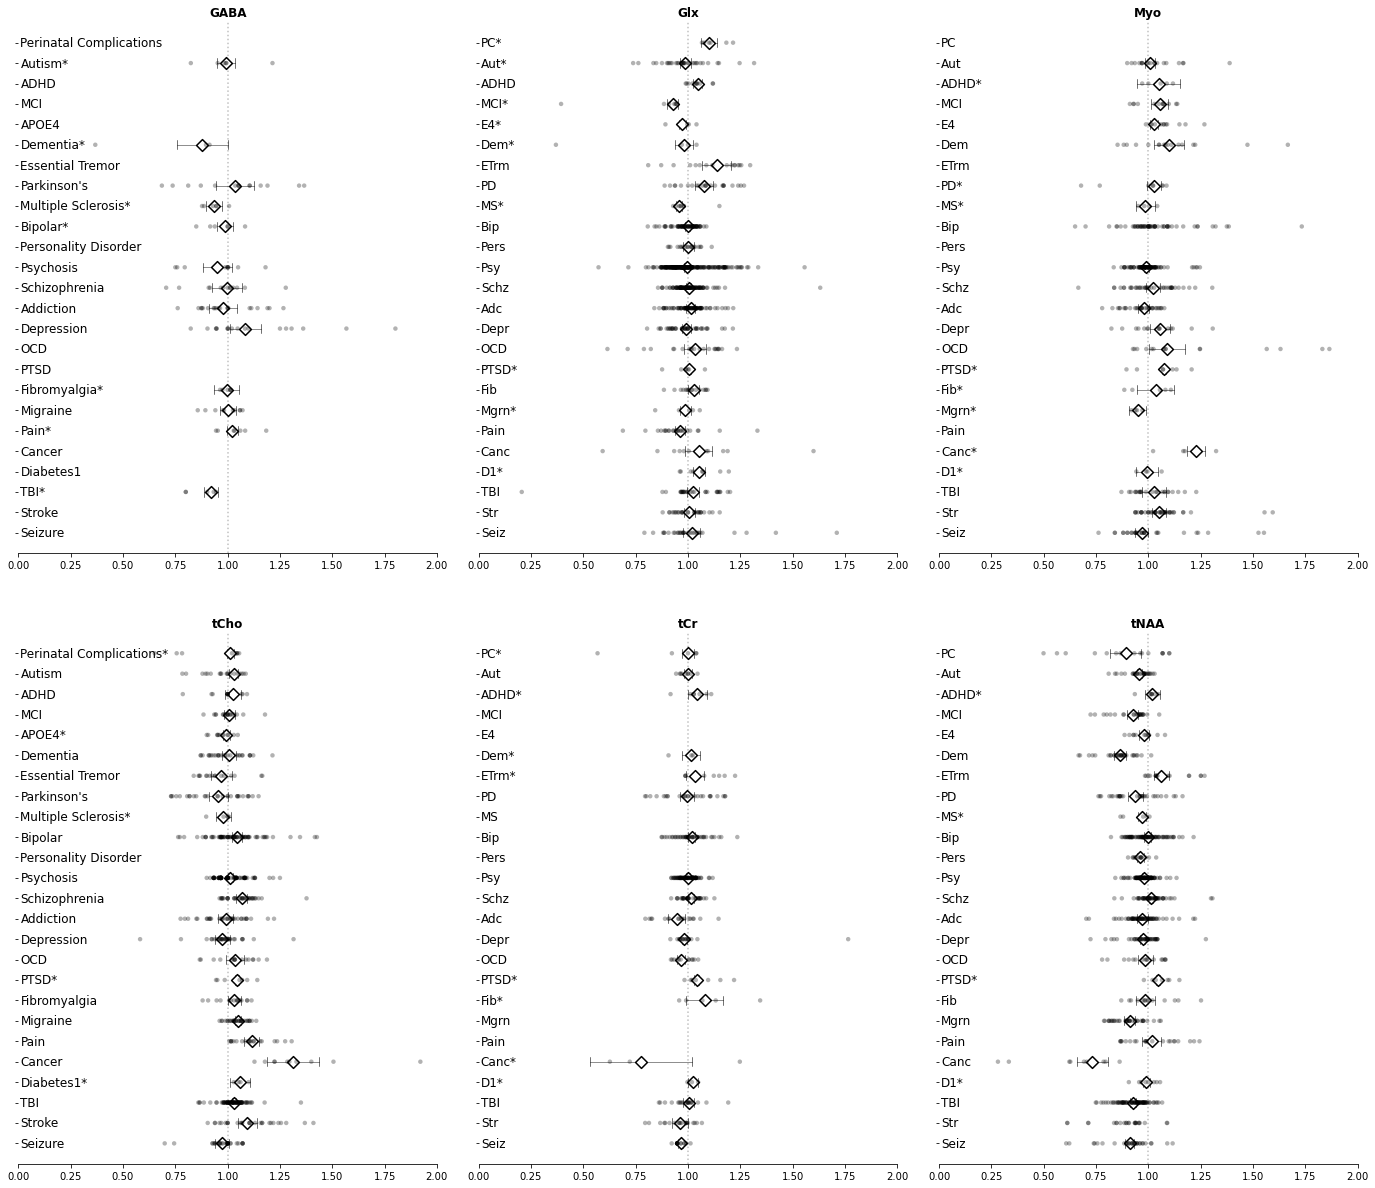

In [39]:

# metabs   = ['Ala', 'Asc', 'Asp', 'Cre', 'tCr', 'GPC', 'tCho', 'GABA', 'Glc', 'Gln', 'Glu', 'Gly', 'Glx', 'GSH', 'Lac', 'Myo', 'NAA', 'PE', 'tNAA', 'NAAG', 'Scy', 'Tau'] 
metabs   =  ['GABA', 'Glx', 'Myo', 'tCho', 'tCr', 'tNAA']

fig,ax   = plt.subplots(2,3,figsize=(24,21))
ax       = np.ravel(ax)

textkwargs = {'horizontalalignment': 'left'  ,
              'verticalalignment'  : 'center',
              'fontsize'           : 12      }

for ii in range(ax.shape[0]):
    ax[ii].axvline(1.0, color='grey', linestyle='dotted', alpha=.5)

dfAbr = pd.DataFrame({'Metabolite': metabs})
    
all_pubs = []
cnt      = 0
for ii in range(len(all_groups)-1, -1, -1):
    eff  = []
    us   = []
    ci_lw= []
    ci_hg= []
    stds = []
    std2 = []
    rngL = []
    rngH = []
    
    for jj in range(len(metabs)):
        df_main_00 = df_main[   df_main.Group == all_groups[ii]].reset_index(drop=True)

        if metabs[jj] == 'tCr':
            df_main_00_= df_main_00[df_main_00.Metabolite == "Cre"].reset_index(drop=True)
        elif metabs[jj] == 'tCho':
            df_main_00_= df_main_00[df_main_00.Metabolite == "GPC"].reset_index(drop=True)
        elif metabs[jj] == 'tNAA':
            df_main_00_= df_main_00[df_main_00.Metabolite == "NAA"].reset_index(drop=True)
        elif metabs[jj] == 'Glx':
            df_main_00_= df_main_00[df_main_00.Metabolite == "Glu"].reset_index(drop=True)
        else:
            df_main_00_ = pd.DataFrame({})
            
        df_main_00 = df_main_00[df_main_00.Metabolite == metabs[jj]].reset_index(drop=True)
        df_main_00 = pd.concat([df_main_00, df_main_00_])
         
        if df_main_00.shape[0] > 2:
            fix    = fixed_effect( df_main_00, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
            ran    = random_effect(df_main_00, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
            u      = np.nan
            
            ast    = ''
            cmplt  = 0
            if np.abs(ran['M']) > .0001 and np.isnan(np.mean(np.array([ran['M'], ran['Low'], ran['Hgh']]))) == False:
                u     = ran['M'  ]
                low   = ran['Low']
                hgh   = ran['Hgh']
                pval  = ran['P-2Tail']
                cmplt = 1
            
            if cmplt == 0 and np.isnan(np.mean(np.array([fix['M'], fix['Low'], fix['Hgh']]))) == False:
                u     = fix['M'  ]
                low   = fix['Low']
                hgh   = fix['Hgh']
                pval  = fix['P-2Tail']
                ast   = '*'
                if df_main_00.shape[0] > 8:
                    print('>8 but FixedEffect', short_names[all_groups[ii]], metabs[jj])
                
            if df_main_00.shape[0] <= 8 or ran['M'] < 0.0:
                u     = fix['M'  ]
                low   = fix['Low']
                hgh   = fix['Hgh']
                pval  = fix['P-2Tail']
                ast   = '*'
            
            if np.isnan(np.mean(np.array([u, low, hgh]))) == True:
                print('{:<4} {:<10}: Fix: {:6.4f} {:6.4f} {:6.4f}  |  Ran: {:6.4f} {:6.4f} {:6.4f}'.format(metabs[jj][:4], short_names[all_groups[ii]][:10], fix['M'], fix['Low'], fix['Hgh'], ran['M'], ran['Low'], ran['Hgh']))
                ast   = ''

            ax[jj].scatter(df_main_00.Friedrich_u.values, np.ones([df_main_00.shape[0]]) * cnt, color='k', edgecolors='none', s=20, alpha=.3, zorder=10)
            
            if np.isnan(np.mean(np.array([u, low, hgh]))) == False:
                ax[jj].plot([low,low], [cnt-.225, cnt+.225], linewidth=.55, color='k', zorder=2)
                ax[jj].plot([hgh,hgh], [cnt-.225, cnt+.225], linewidth=.55, color='k', zorder=2)
                ax[jj].plot([low,hgh], [cnt, cnt], linewidth=.55, color='k', alpha=.8, zorder=2)
                ax[jj].scatter(u, cnt, color='white', edgecolors='k', marker=(4, 0, 90), s=140, linewidth=1.5, zorder=5)

            ## If plotting both Random and Fixed Effects Models
            # ax[jj].scatter(ran[ 0], cnt, color='royalblue', edgecolors='k', marker=(4, 0, 90), s=140, linewidth=1.5, zorder=0)
            # ax[jj].scatter(fix[ 0], cnt, color='firebrick', edgecolors='k', marker=(4, 0, 90), s=140, linewidth=1.5, zorder=0)
            
            # ax[jj].text(0.40, cnt, df_main_00.shape[0]        , **textkwargs)                       # N Subjects In Study
            # ax[jj].text(0.50, cnt, short_names[all_groups[ii]], **textkwargs)                       # Group Name
            # ax[jj].text(1.55, cnt, '{:6.3f} [{:4.2f}, {:4.2f}]'.format(u, low, hgh), **textkwargs)  # Combined Effects
            # ax[jj].text(0.01, cnt, '{}{}'.format(short_names[all_groups[ii]], ast), **textkwargs)   # Random or Fixed Effect
            
            if jj in [0,3]:
                ax[jj].text(0.01, cnt, '{}{}'.format(all_groups[ii].replace('_', ' '), ast), **textkwargs)
            else:
                ax[jj].text(0.01, cnt, '{}{}'.format(short_names[all_groups[ii]], ast), **textkwargs)
        else:
            if jj in [0,3]:
                ax[jj].text(0.01, cnt, '{}'.format(all_groups[ii]).replace('_', ' '), **textkwargs)
            else:
                ax[jj].text(0.01, cnt, '{}'.format(short_names[all_groups[ii]]), **textkwargs)

    cnt +=1
    
for ii in range(len(metabs)):
    # ax[ii].text(0.40, cnt, 'N'               , **textkwargs, fontweight='bold')   # Column Name - Ns
    # ax[ii].text(0.50, cnt, 'Group'           , **textkwargs, fontweight='bold')   # Column Name - Group
    # ax[ii].text(1.55, cnt, 'Ratio     95% CI', **textkwargs, fontweight='bold')   # Column Name - Combined Effects
    
    ax[ii].set_title(metabs[ii], fontsize=12, fontweight='bold' )
    ax[ii].set_yticks([y for y in range(0, cnt)]) 
    ax[ii].set_yticklabels([])
    ax[ii].spines['top'   ].set_visible(False)
    ax[ii].spines['left'  ].set_visible(False)
    ax[ii].spines['right' ].set_visible(False)
    ax[ii].set_xlim([0.00, 2.00])
    ax[ii].set_ylim([-1.0, len(all_groups)])
    
    ax[ii].xaxis.set_tick_params(width=.80)                                         # Set ticks to .85 to identify same weight in Illustrator
    ax[ii].yaxis.set_tick_params(width=.80)                                         # Set ticks to .85 to identify same weight in Illustrator

plt.subplots_adjust(wspace=.1, hspace=.15)                                          # Space between Plots
# plt.show()
plt.savefig('Clinical_Control_With_Scatter.pdf', dpi=300, transparent=True)


## Metabolite Complexes Separate vs. Combined

NAA  Str       : Fix:    nan    nan    nan  |  Ran:    nan    nan    nan
TNAA Str       : Fix:    nan    nan    nan  |  Ran:    nan    nan    nan
Cre  TBI       : Fix: 1.0020 0.9833 1.0207  |  Ran: 0.9966    nan    nan
>8 but FixedEffect TBI Cre
tNAA ETrm      : Fix: 1.0279 0.9845 1.0713  |  Ran: 1.0346    nan    nan
Glx  ETrm      : Fix: 1.2419 1.1651 1.3188  |  Ran: 1.2294    nan    nan
GPC  E4        : Fix: 0.9959 0.9686 1.0232  |  Ran: 1.0269    nan    nan
>8 but FixedEffect E4 GPC
TCho E4        : Fix: 0.9933 0.9777 1.0090  |  Ran: 0.9753    nan    nan
>8 but FixedEffect E4 TCho
tCr  ADHD      : Fix: 1.0449 1.0005 1.0894  |  Ran: 1.0665    nan    nan
TCr  ADHD      : Fix: 1.0449 1.0005 1.0894  |  Ran: 1.0665    nan    nan
tNAA ADHD      : Fix: 1.0188 0.9823 1.0552  |  Ran: 1.0916    nan    nan
TNAA ADHD      : Fix: 1.0188 0.9823 1.0552  |  Ran: 1.0916    nan    nan
NAA  Aut       : Fix: 0.9488 0.9197 0.9779  |  Ran: 0.9551    nan    nan
>8 but FixedEffect Aut NAA
Glu  Aut       : 

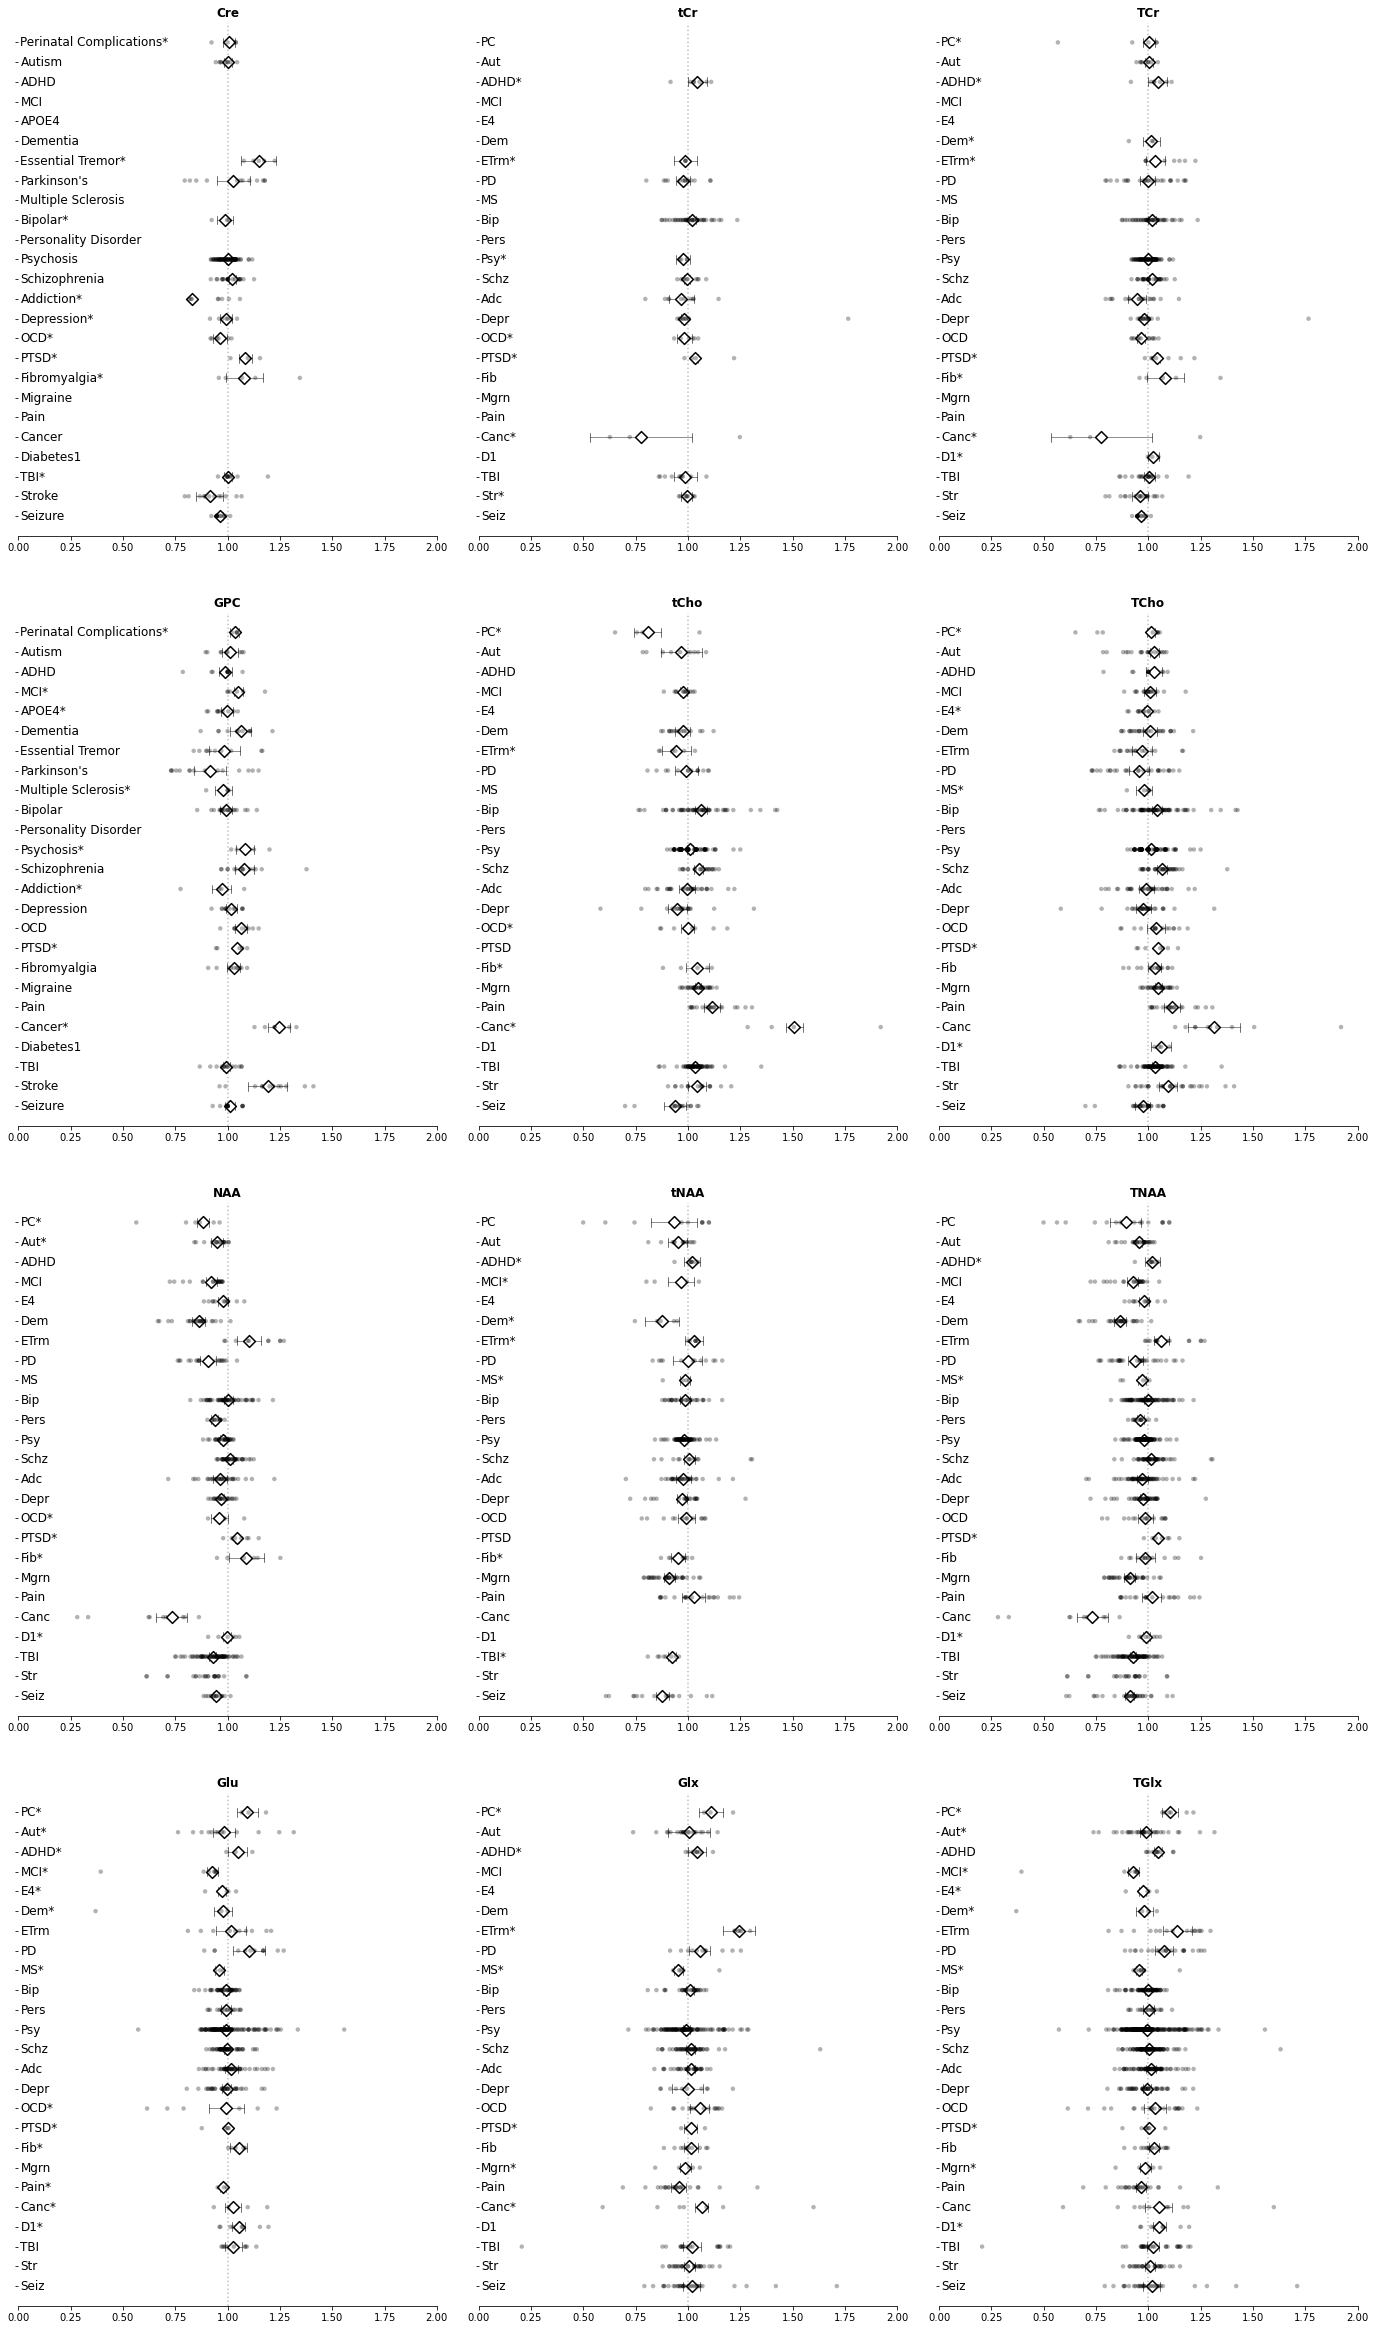

In [45]:

metabs   = ['Cre' , 'tCr' , 'TCr' ,
            'GPC' , 'tCho', 'TCho',
            'NAA' , 'tNAA', 'TNAA',
            'Glu' , 'Glx' , 'TGlx'] 

fig,ax   = plt.subplots(4,3,figsize=(24,21*2))
ax       = np.ravel(ax)

textkwargs = {'horizontalalignment': 'left'  ,
              'verticalalignment'  : 'center',
              'fontsize'           : 12      }

for ii in range(ax.shape[0]):
    ax[ii].axvline(1.0, color='grey', linestyle='dotted', alpha=.5)

dfAbr = pd.DataFrame({'Metabolite': metabs})
    
all_pubs = []
cnt      = 0
for ii in range(len(all_groups)-1, -1, -1):
    eff  = []
    us   = []
    ci_lw= []
    ci_hg= []
    stds = []
    std2 = []
    rngL = []
    rngH = []
    
    for jj in range(len(metabs)):
        df_main_00 = df_main[   df_main.Group == all_groups[ii]].reset_index(drop=True)
         
        if metabs[jj] == 'TCr':
            df_main_00_= df_main_00[df_main_00.Metabolite == 'Cre' ].reset_index(drop=True)
            df_main_01_= df_main_00[df_main_00.Metabolite == 'tCr' ].reset_index(drop=True)
        elif metabs[jj] == 'TCho':
            df_main_00_= df_main_00[df_main_00.Metabolite == 'GPC' ].reset_index(drop=True)
            df_main_01_= df_main_00[df_main_00.Metabolite == 'tCho'].reset_index(drop=True)
        elif metabs[jj] == 'TNAA':
            df_main_00_= df_main_00[df_main_00.Metabolite == 'NAA' ].reset_index(drop=True)
            df_main_01_= df_main_00[df_main_00.Metabolite == 'tNAA'].reset_index(drop=True)
        elif metabs[jj] == 'TGlx':
            df_main_00_= df_main_00[df_main_00.Metabolite == 'Glu' ].reset_index(drop=True)
            df_main_01_= df_main_00[df_main_00.Metabolite == 'Glx' ].reset_index(drop=True)
        else:
            df_main_00_ = pd.DataFrame({})
            df_main_01_ = pd.DataFrame({})
            
        df_main_00 = df_main_00[df_main_00.Metabolite == metabs[jj]].reset_index(drop=True)
        df_main_00 = pd.concat([df_main_00, df_main_00_, df_main_01_])
            
        if df_main_00.shape[0] > 2:
            fix    = fixed_effect( df_main_00, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
            ran    = random_effect(df_main_00, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
            u      = np.nan
            
            ast    = ''
            cmplt  = 0
            if np.abs(ran['M']) > .0001 and np.isnan(np.mean(np.array([ran['M'], ran['Low'], ran['Hgh']]))) == False:
                u     = ran['M'  ]
                low   = ran['Low']
                hgh   = ran['Hgh']
                pval  = ran['P-2Tail']
                cmplt = 1
            
            if cmplt == 0 and np.isnan(np.mean(np.array([fix['M'], fix['Low'], fix['Hgh']]))) == False:
                u     = fix['M'  ]
                low   = fix['Low']
                hgh   = fix['Hgh']
                pval  = fix['P-2Tail']
                ast   = '*'
                if df_main_00.shape[0] > 8:
                    print('>8 but FixedEffect', short_names[all_groups[ii]], metabs[jj])
                
            if df_main_00.shape[0] <= 8 or ran['M'] < 0.0:
                u     = fix['M'  ]
                low   = fix['Low']
                hgh   = fix['Hgh']
                pval  = fix['P-2Tail']
                ast   = '*'
            
            if np.isnan(np.mean(np.array([u, low, hgh]))) == True:
                print('{:<4} {:<10}: Fix: {:6.4f} {:6.4f} {:6.4f}  |  Ran: {:6.4f} {:6.4f} {:6.4f}'.format(metabs[jj][:4], short_names[all_groups[ii]][:10], fix['M'], fix['Low'], fix['Hgh'], ran['M'], ran['Low'], ran['Hgh']))
                ast   = ''

            ax[jj].scatter(df_main_00.Friedrich_u.values, np.ones([df_main_00.shape[0]]) * cnt, color='k', edgecolors='none', s=20, alpha=.3, zorder=10)
            
            if np.isnan(np.mean(np.array([u, low, hgh]))) == False:
                ax[jj].plot([low,low], [cnt-.225, cnt+.225], linewidth=.55, color='k', zorder=2)
                ax[jj].plot([hgh,hgh], [cnt-.225, cnt+.225], linewidth=.55, color='k', zorder=2)
                ax[jj].plot([low,hgh], [cnt, cnt], linewidth=.55, color='k', alpha=.8, zorder=2)
                ax[jj].scatter(u, cnt, color='white', edgecolors='k', marker=(4, 0, 90), s=140, linewidth=1.5, zorder=5)

            ## If plotting both Random and Fixed Effects Models
            # ax[jj].scatter(ran[ 0], cnt, color='royalblue', edgecolors='k', marker=(4, 0, 90), s=140, linewidth=1.5, zorder=0)
            # ax[jj].scatter(fix[ 0], cnt, color='firebrick', edgecolors='k', marker=(4, 0, 90), s=140, linewidth=1.5, zorder=0)
            
            # ax[jj].text(0.40, cnt, df_main_00.shape[0]        , **textkwargs)                       # N Subjects In Study
            # ax[jj].text(0.50, cnt, short_names[all_groups[ii]], **textkwargs)                       # Group Name
            # ax[jj].text(1.55, cnt, '{:6.3f} [{:4.2f}, {:4.2f}]'.format(u, low, hgh), **textkwargs)  # Combined Effects
            # ax[jj].text(0.01, cnt, '{}{}'.format(short_names[all_groups[ii]], ast), **textkwargs)   # Random or Fixed Effect
            
            if jj in [0,3]:
                ax[jj].text(0.01, cnt, '{}{}'.format(all_groups[ii].replace('_', ' '), ast), **textkwargs)
            else:
                ax[jj].text(0.01, cnt, '{}{}'.format(short_names[all_groups[ii]], ast), **textkwargs)
        else:
            if jj in [0,3]:
                ax[jj].text(0.01, cnt, '{}'.format(all_groups[ii]).replace('_', ' '), **textkwargs)
            else:
                ax[jj].text(0.01, cnt, '{}'.format(short_names[all_groups[ii]]), **textkwargs)

    cnt +=1
    
for ii in range(len(metabs)):
    # ax[ii].text(0.40, cnt, 'N'               , **textkwargs, fontweight='bold')   # Column Name - Ns
    # ax[ii].text(0.50, cnt, 'Group'           , **textkwargs, fontweight='bold')   # Column Name - Group
    # ax[ii].text(1.55, cnt, 'Ratio     95% CI', **textkwargs, fontweight='bold')   # Column Name - Combined Effects
    
    ax[ii].set_title(metabs[ii], fontsize=12, fontweight='bold' )
    ax[ii].set_yticks([y for y in range(0, cnt)]) 
    ax[ii].set_yticklabels([])
    ax[ii].spines['top'   ].set_visible(False)
    ax[ii].spines['left'  ].set_visible(False)
    ax[ii].spines['right' ].set_visible(False)
    ax[ii].set_xlim([0.00, 2.00])
    ax[ii].set_ylim([-1.0, len(all_groups)])
    
    ax[ii].xaxis.set_tick_params(width=.80)                                         # Set ticks to .85 to identify same weight in Illustrator
    ax[ii].yaxis.set_tick_params(width=.80)                                         # Set ticks to .85 to identify same weight in Illustrator

plt.subplots_adjust(wspace=.1, hspace=.15)                                          # Space between Plots
plt.show()


In [39]:

metabs   = ['Asc', 'Asp', 'tCr', 'tCho', 'GABA', 'Gln', 'Glx', 'Gly', 'GSH', 'Lac', 'Myo', 'PE', 'tNAA', 'NAAG', 'Scy', 'Tau'] # 'Ala',  

df_n    = []
df_u    = []
df_grp  = []
df_met  = []
df_low  = []
df_hgh  = []
df_std  = []
df_eff  = []

all_pubs = []
cnt      = 0
for ii in range(len(all_groups)-1, -1, -1):    
    df_main_00 = df_main[   df_main.Group == all_groups[ii]].reset_index(drop=True)

    for jj in range(len(metabs)): 
        df_main_00_ = copy.deepcopy(df_main_00) 
        df_main_00_ = df_main_00_[df_main_00_.Metabolite == metabs[jj]].reset_index(drop=True)
        
        if metabs[jj] == 'tCr':
            df_main_01_= df_main_00[df_main_00.Metabolite == "Cre"].reset_index(drop=True)
        elif metabs[jj] == 'tCho':
            df_main_01_= df_main_00[df_main_00.Metabolite == "GPC"].reset_index(drop=True)
        elif metabs[jj] == 'tNAA':
            df_main_01_= df_main_00[df_main_00.Metabolite == "NAA"].reset_index(drop=True)
        elif metabs[jj] == 'Glx':
            df_main_01_= df_main_00[df_main_00.Metabolite == "Glu"].reset_index(drop=True)
        else:
            df_main_01_ = pd.DataFrame({})

        df_main_00_ = pd.concat([df_main_01_, df_main_00_])
 
        if df_main_00_.shape[0] > 2:
            
            fix    = fixed_effect( df_main_00_, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
            ran    = random_effect(df_main_00_, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
            u      = np.nan
           
            cmplt  = 0
            if np.abs(ran['M']) > .0001 and np.isnan(np.mean(np.array([ran['M'], ran['Low'], ran['Hgh']]))) == False:
                u     = ran['M'  ]
                low   = ran['Low']
                hgh   = ran['Hgh']
                pval  = ran['P-2Tail']
                cmplt = 1
                effect= 'Random'
            
            if cmplt == 0 and np.isnan(np.mean(np.array([fix['M'], fix['Low'], fix['Hgh']]))) == False:
                u     = fix['M'  ]
                low   = fix['Low']
                hgh   = fix['Hgh']
                pval  = fix['P-2Tail']
                effect= 'Fixed'
                if df_main_00_.shape[0] > 8:
                    print('>8 but FixedEffect', short_names[all_groups[ii]], metabs[jj])
                
            if df_main_00_.shape[0] <= 8 or ran['M'] < 0.0:
                u     = fix['M'  ]
                low   = fix['Low']
                hgh   = fix['Hgh']
                pval  = fix['P-2Tail']
                effect= 'Fixed'
                        
            if np.isnan(np.mean(np.array([u, low, hgh]))) == False:
                std  = (hgh - low)/ 3.92 * np.sqrt(df_main_00_.shape[0])

                df_u.append(u)
                df_n.append(df_main_00_.shape[0])
                df_grp.append(all_groups[ii])
                df_met.append(metabs[jj])
                df_low.append(low)
                df_hgh.append(hgh)
                df_std.append(std)
                df_eff.append(effect)
                    
df_vals = pd.DataFrame({'Metabolite': df_met,
                        'Groups'    : df_grp,
                        'N'         : df_n  ,
                        'Mean'      : df_u  ,
                        'StdDev'    : df_std,
                        'CI_Low'    : df_low,
                        'CI_High'   : df_hgh,
                        'Effect'    : df_eff})
# display(df_vals.sort_values(by=['Metabolite']))
df_vals.to_csv('Results_Concentration_Clinical.csv')

>8 but FixedEffect TBI Cre
>8 but FixedEffect E4 GPC
>8 but FixedEffect Aut Glu
>8 but FixedEffect Aut NAA


,Metabolite,Groups,N,Mean,StdDev,CI_Low,CI_High,Effect
0,Cre,Seizure,15,0.965337,0.072393,0.953388,0.977287,Random
1,GPC,Seizure,15,1.011163,0.137259,0.988506,1.033819,Random
2,tCho,Seizure,16,0.938569,0.308701,0.887615,0.989524,Random
3,Glx,Seizure,30,1.016980,0.248972,0.975885,1.058076,Random
4,Myo,Seizure,30,0.967977,0.179752,0.938307,0.997647,Random
5,NAA,Seizure,15,0.946020,0.090925,0.931012,0.961029,Random
6,tNAA,Seizure,16,0.876577,0.186916,0.845724,0.907429,Random
7,Cre,Stroke,12,0.914699,0.427338,0.849295,0.980103,Random
8,tCr,Stroke,8,0.993262,0.161990,0.968470,1.018055,Fixed
9,GPC,Stroke,12,1.190676,0.621151,1.095609,1.285744,Random


## Double Check for Extreme Values

In [12]:

metabs      = ['Ala', 'Asc', 'Asp', 'Cre', 'tCr', 'GPC', 'tCho', 'GABA', 'Glc', 'Gln', 'Glu', 'Gly', 'Glx', 'GSH', 'Lac', 'Myo', 'NAA', 'PE', 'tNAA', 'NAAG', 'Scy', 'Tau']
clsses      = ['Perinatal_Complications', 'Autism', 'ADHD', 
               'MCI', 'APOE4', 'Dementia', 'Essential Tremor', 'Parkinson\'s', 'Multiple Sclerosis',
               'Bipolar', 'Personality Disorder', 'Psychosis', 'Schizophrenia',
               'Addiction', 'Depression', 'OCD', 'PTSD',
               'Fibromyalgia', 'Migraine', 'Pain', 'Cancer', 'Diabetes1', 'TBI', 'Stroke', 'Seizure']

for ii in range(len(metabs)):
    print(' ')
    for jj in range(len(clsses)):

        ustr    = 'Friedrich_u'
        sdstr   = 'Friedrich_SE'
        vstr    = 'Friedrich_Var'
        wstr    = 'Friedrich_Weight'

        try:
            a       = df_main[df_main.Metabolite == metabs[ii]].reset_index(drop=True)
            a       = a[a.Group == clsses[jj]].reset_index(drop=True)
            a       = copy.deepcopy(a[['Reference', 'ID', ustr, vstr, wstr, sdstr]])
            a['Wgt']= a[wstr] / np.sum(a[wstr])

            for kk in range(a.shape[0]):
                val_wgt  = a.Friedrich_Weight.values[kk]
                val_wgt /= np.sum(a.Friedrich_Weight.values)
                
                if a.shape[0] < 10 and a.shape[0] > 2:
                    if val_wgt > .30:
                        print('{:<4} {:<20}:  {:<8}  {:2d}  |  1/{:3d} {:6.3f}  {:7.2f}   |   {:7.3f} {:7.5f} '.format(metabs[ii][:4], a.Reference.values[kk][:20], clsses[jj][:8], int(a.ID.values[kk]), a.shape[0], 100*(1/a.shape[0]), 100*val_wgt, a[ustr].values[kk], a[vstr].values[kk]))

                elif a.shape[0] < 20 and a.shape[0] > 2:
                    if val_wgt > .18:
                        print('{:<4} {:<20}:  {:<8}  {:2d}  |  1/{:3d} {:6.3f}  {:7.2f}   |   {:7.3f} {:7.5f} '.format(metabs[ii][:4], a.Reference.values[kk][:20], clsses[jj][:8], int(a.ID.values[kk]), a.shape[0], 100*(1/a.shape[0]), 100*val_wgt, a[ustr].values[kk], a[vstr].values[kk]))

                elif a.shape[0] > 2:
                    if val_wgt > .075:
                        print('{:<4} {:<20}:  {:<8}  {:2d}  |  1/{:3d} {:6.3f}  {:7.2f}   |   {:7.3f} {:7.5f} '.format(metabs[ii][:4], a.Reference.values[kk][:20], clsses[jj][:8], int(a.ID.values[kk]), a.shape[0], 100*(1/a.shape[0]), 100*val_wgt, a[ustr].values[kk], a[vstr].values[kk]))
                else:
                    print('{:<4}:  ---  ****'.format(metabs[ii][:4]))
        
        except Exception as e:
            print('{:<4}:  ---  {}'.format(metabs[ii][:4], e))
 

 
Ala :  ---  ****
 
Asc :  ---  ****
Asc :  ---  ****
 
Asp :  ---  ****
Asp :  ---  ****
Asp  2019_marjanska_68   :  Dementia   1  |  1/  3 33.333    53.31   |     1.071 0.00315 
Asp  2019_marjanska_68   :  Dementia   2  |  1/  3 33.333    45.90   |     1.149 0.00365 
Asp :  ---  ****
Asp  2019_starmose_20    :  Migraine   3  |  1/  4 25.000    45.21   |     0.620 0.00059 
Asp :  ---  ****
Asp :  ---  ****
Asp :  ---  ****
Asp :  ---  ****
 
Cre  2017_sijens_42      :  Perinata  18  |  1/  4 25.000    46.38   |     1.000 0.00046 
Cre :  ---  ****
Cre :  ---  ****
Cre  2018_huber_225      :  Bipolar    1  |  1/  3 33.333    31.41   |     0.997 0.00110 
Cre  2021_mansur_281     :  Bipolar    2  |  1/  3 33.333    49.85   |     1.005 0.00069 
Cre  2019_iwata_85       :  Schizoph   5  |  1/ 22  4.545    10.24   |     1.057 0.00059 
Cre  2019_iwata_85       :  Schizoph   7  |  1/ 22  4.545     8.37   |     1.056 0.00072 
Cre  2019_iwata_85       :  Schizoph   8  |  1/ 22  4.545    11.33  